In [4]:
import gym
import traci
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sys
import matplotlib.pyplot as plt
import random
from collections import deque
import pickle

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
class TrafficSignal:
    def __init__(self, traffic_light_id):
        self.id = traffic_light_id
        self.current_phase = traci.trafficlight.getPhase(traffic_light_id)
        self.lanes = traci.trafficlight.getControlledLanes(traffic_light_id)
        self.last_step_vehicle_number = 0
        self.last_step_mean_waiting_time = 0
        self.update_state_cache()

    def update_state_cache(self):
        self.last_step_vehicle_number = sum(traci.lane.getLastStepVehicleNumber(lane) for lane in self.lanes)
        total_waiting_time = sum(traci.lane.getWaitingTime(lane) for lane in self.lanes)
        self.last_step_mean_waiting_time = (total_waiting_time / self.last_step_vehicle_number if self.last_step_vehicle_number > 0 else 0)

    def get_state(self):
        return {
            'current_phase': self.current_phase,
            'vehicle_number': self.last_step_vehicle_number,
            'mean_waiting_time': self.last_step_mean_waiting_time
        }

    def get_state_as_array(self):
        return [self.current_phase, self.last_step_vehicle_number, self.last_step_mean_waiting_time]

    def set_phase(self, phase_index):
        self.current_phase = phase_index
        traci.trafficlight.setPhase(self.id, phase_index)

class TrafficEnvironment(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, use_gui=False):
        super(TrafficEnvironment, self).__init__()
        try:
            if use_gui:
                traci.start(['C:\\Program Files (x86)\\Eclipse\\Sumo\\bin\\sumo-gui', '-c', 'C:\\Users\\Aravind Balachandar\\Downloads\\RL\\config.sumocfg', '--start', "--no-warnings", "true"])
            else:
                traci.start(['C:\\Program Files (x86)\\Eclipse\\Sumo\\bin\\sumo', '-c', 'C:\\Users\\Aravind Balachandar\\Downloads\\RL\\config.sumocfg', '--start', "--no-warnings", "true"])
        except Exception as e:
            print(f"Failed to start SUMO via TraCI: {e}")
            sys.exit("Exiting due to failure connecting to SUMO.")

        self.traffic_signals = [TrafficSignal(tls_id) for tls_id in traci.trafficlight.getIDList()]
        self.action_space = gym.spaces.Dict({
            signal.id: gym.spaces.Discrete(len(traci.trafficlight.getAllProgramLogics(signal.id)[0].getPhases())) 
            for signal in self.traffic_signals
        })
        self.observation_space = gym.spaces.Dict({
            signal.id: gym.spaces.Box(low=np.array([0, 0, 0]), high=np.array([len(traci.trafficlight.getAllProgramLogics(signal.id)[0].getPhases())-1, np.inf, np.inf]), dtype=np.float32)
            for signal in self.traffic_signals
        })
        self.steps = 0
        self.max_steps = 1000

    def step(self, actions):
        traci.simulationStep()
        rewards = {}
        observations = {}
        dones = {}

        for signal in self.traffic_signals:
            signal.update_state_cache()
            action = actions[signal.id]
            signal.set_phase(action)
            state = signal.get_state()
            observations[signal.id] = signal.get_state_as_array()
            rewards[signal.id] = -(state['mean_waiting_time'] * state['vehicle_number'])
            dones[signal.id] = not (traci.simulation.getMinExpectedNumber() > 0)

        done = all(dones.values())
        info = {'n': {signal.id: signal.get_state() for signal in self.traffic_signals}}
        
        self.steps += 1
        if self.steps >= self.max_steps:
            done = True

        return observations, rewards, done, info

    def reset(self):
        self.steps = 0
        traci.load(['-c', 'config.sumocfg', '--start', "--no-warnings", "true"])
        for signal in self.traffic_signals:
            signal.update_state_cache()
        return {signal.id: signal.get_state_as_array() for signal in self.traffic_signals}

    def render(self, mode='human'):
        pass

    def close(self):
        traci.close()

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, output_dim)
        self.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

class MARLAgent:
    def __init__(self, input_dim, output_dim, lr, gamma, epsilon, batch_size, threshold_reward=None):
        self.dqn = DQN(input_dim, output_dim)
        self.target_dqn = DQN(input_dim, output_dim)
        self.target_dqn.load_state_dict(self.dqn.state_dict())
        self.target_dqn.eval()
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.gamma = gamma
        self.epsilon = epsilon
        self.output_dim = output_dim
        self.replay_buffer = deque(maxlen=batch_size)
        self.batch_size = batch_size
        self.threshold_reward = threshold_reward

    def choose_action(self, state):
        if np.random.random() > self.epsilon:
            state = torch.tensor([state], dtype=torch.float32).to(device)
            actions = self.dqn(state)
            action = torch.argmax(actions).item()
        else:
            action = np.random.choice(self.output_dim)
        return action

    def train(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

        if len(self.replay_buffer) < self.batch_size:
            return

        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.long).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).to(device)

        q_values = self.dqn(states)
        next_q_values = self.target_dqn(next_states).detach()

        q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_value = next_q_values.max(1)[0]
        expected_q_value = rewards + self.gamma * next_q_value * (1 - dones)

        loss = self.criterion(q_value, expected_q_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_dqn.load_state_dict(self.dqn.state_dict())

    def evaluate(self, state):
        state_tensor = torch.FloatTensor(state).to(device)
        with torch.no_grad():
            action = torch.argmax(self.dqn(state_tensor)).item()
        return action
    def save_models(self, path):
        for signal_id, agent in self.agents.items():
            with open(f"{path}/agent_{signal_id}_dqn.pickle", 'wb') as f:
                pickle.dump(agent.dqn.state_dict(), f)

class MARLDQNAgent:
    def __init__(self, env, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_min=0.01,
                 batch_size=200, threshold_reward=None):
        self.agents = {signal.id: MARLAgent(env.observation_space[signal.id].shape[0],
                                             env.action_space[signal.id].n,
                                             lr, gamma, epsilon, batch_size, threshold_reward)
                       for signal in env.traffic_signals}
        self.epsilon_decay = 0
        self.epsilon_min = epsilon_min

    def choose_actions(self, states):
        actions = {}
        for signal_id, state in states.items():
            actions[signal_id] = self.agents[signal_id].choose_action(state)
        return actions

    def train(self, env, episodes):
        initial_epsilon = self.agents[next(iter(self.agents))].epsilon
        self.epsilon_decay = (0.01 / initial_epsilon) ** (1 / episodes)
        rewards = []
        epsilons = []
        for episode in range(episodes):
            state = env.reset()
            done = False
            total_reward = 0
            while not done:
                actions = self.choose_actions(state)
                next_state, reward, done, _ = env.step(actions)
                for signal_id, agent in self.agents.items():
                    agent.train(state[signal_id], actions[signal_id], reward[signal_id], next_state[signal_id], done)
                state = next_state
                total_reward += sum(reward.values())

            rewards.append(total_reward)
            epsilons.append(initial_epsilon)

            if episode % 2 == 0:
                for agent in self.agents.values():
                    agent.update_target_network()

            for _ , agent in self.agents.items():
                if agent.epsilon > self.epsilon_min:
                    agent.epsilon *= self.epsilon_decay

            print(f"Training episode {episode+1} out of {episodes} completed")
        return rewards, epsilons

    def evaluate(self, env, episodes):
        rewards = []
        for episode in range(episodes):
            state = env.reset()
            done = False
            total_reward = 0
            while not done:
                actions = {}
                for signal_id, agent in self.agents.items():
                    actions[signal_id] = agent.evaluate(state[signal_id])
                next_state, reward, done, _ = env.step(actions)
                state = next_state
                total_reward += sum(reward.values())
            rewards.append(total_reward)
            print(f"Evaluation episode {episode+1} out of {episodes} completed")
        return rewards
    
    def save_models(self, path):
        for agent_id, marl_agent in self.agents.items():
            with open(f"{path}/agent_{agent_id}_dqn.pickle", 'wb') as f:
                pickle.dump(marl_agent.dqn.state_dict(), f)

In [8]:
env = TrafficEnvironment(use_gui=False)
agent = MARLDQNAgent(env)

for agent_id, marl_agent in agent.agents.items():
    marl_agent.dqn.to(device)
    marl_agent.target_dqn.to(device)

num_episodes = 1000
train_rewards, train_epsilons = agent.train(env, num_episodes)

# agent.save_models("./models")

evaluation_episodes = 10
evaluation_rewards = agent.evaluate(env, evaluation_episodes)
env.close()

Training episode 1 out of 1000 completed
Training episode 2 out of 1000 completed
Training episode 3 out of 1000 completed
Training episode 4 out of 1000 completed
Training episode 5 out of 1000 completed
Training episode 6 out of 1000 completed
Training episode 7 out of 1000 completed
Training episode 8 out of 1000 completed
Training episode 9 out of 1000 completed
Training episode 10 out of 1000 completed
Training episode 11 out of 1000 completed
Training episode 12 out of 1000 completed
Training episode 13 out of 1000 completed
Training episode 14 out of 1000 completed
Training episode 15 out of 1000 completed
Training episode 16 out of 1000 completed
Training episode 17 out of 1000 completed
Training episode 18 out of 1000 completed
Training episode 19 out of 1000 completed
Training episode 20 out of 1000 completed
Training episode 21 out of 1000 completed
Training episode 22 out of 1000 completed
Training episode 23 out of 1000 completed
Training episode 24 out of 1000 completed
T

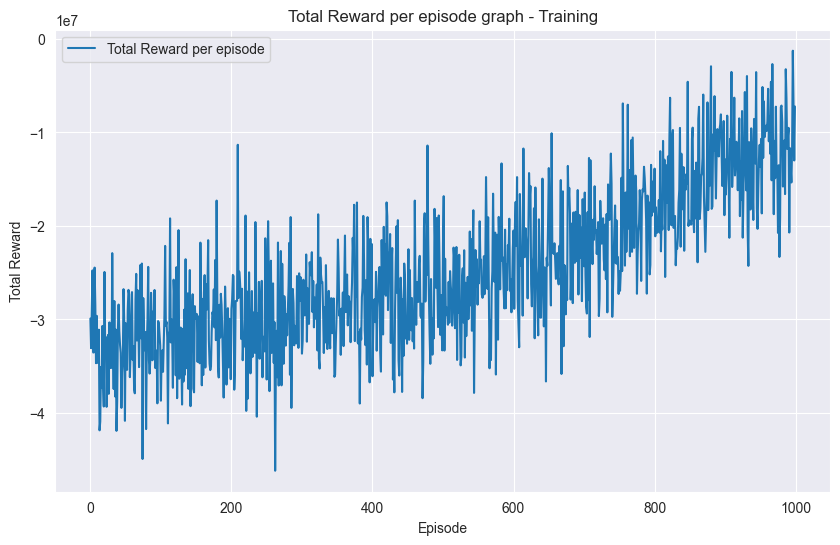

In [109]:
plt.figure(figsize=(10, 6))
plt.title('Total Reward per episode graph - Training')
plt.plot(train_rewards, label='Total Reward per episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

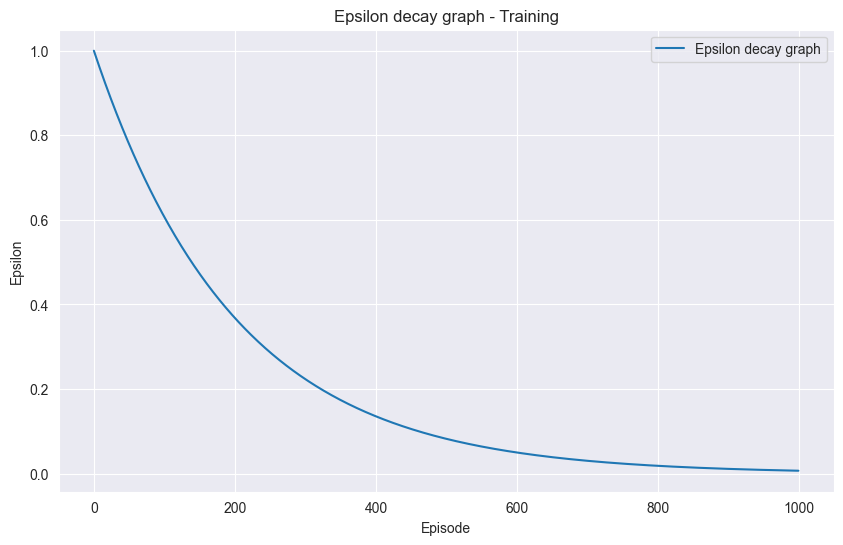

In [111]:

plt.figure(figsize=(10, 6))
plt.title('Epsilon decay graph - Training')
plt.plot(train_epsilons, label='Epsilon decay graph')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.legend()
plt.show()

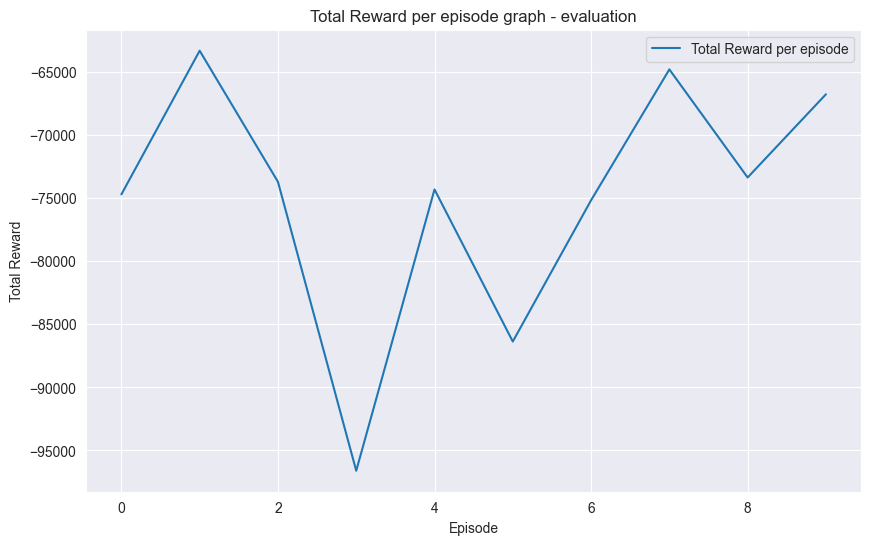

In [113]:
plt.figure(figsize=(10, 6))
plt.title('Total Reward per episode graph - evaluation')
plt.plot(evaluation_rewards, label='Total Reward per episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()